# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import plotly.express as px #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline



Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Значения столбцов таблицы:

- RowNumber — номер строки таблицы;
- CustomerId — идентификатор клиента;
- Surname — фамилия клиента;
- CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
- Geography — страна проживания клиента (банк межнациональный);
- Gender — пол клиента;
- Age — возраст клиента;
- Tenure — сколько лет клиент пользуется банком;
- Balance — сколько у клиента денег на счетах в банке;
- NumOfProduct — число услуг банка, которыми воспользовался клиент;
- HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
- IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
- EstimatedSalary — предполагаемая заработная плата клиента;
- Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
# Создаем копию датафрейма
churn_data_temp = churn_data.copy()



# фильтруем клиентов по размеру баланса
clienrs_with_money = churn_data_temp[churn_data_temp['Balance'] > 2500]
# строим гистограмму по отфильтрованному дата фрейму
fig = px.histogram(data_frame=clienrs_with_money['Balance'],
                    x='Balance',
                    labels={'Balance': 'Баланс на счету клиента', 'y': 'Количество клиентов'},
                    marginal='box',
                    nbins=30,
                    width=800, #ширина
                    height=500, #высота
                    title='Распределение баланса пользователей'
                    )
# дополняем гистограмму наименование оси
fig.update_layout(yaxis_title="Количество клиентов")
fig.show()

Наибольшее количество клиентов с балансом более 2,5 тыс. долларов, имеют баланс от 90 до 150 тыс. доларов, при этом отсутствут клиенты с балансом более 251 тыс. долларов.

In [4]:
# группируем клиентов по полу
grouped_by_gender = churn_data_temp.groupby(['Gender'])['Exited'].mean()

# Преобразуем Series в DataFrame
grouped_by_gender_df = grouped_by_gender.reset_index()
grouped_by_gender_df.columns = ['Gender', 'Exited']
# строим столбчатую диаграмму
fig = px.bar(
    data_frame=grouped_by_gender_df,
    x='Gender',
    y='Exited',
    color='Gender',
    height=500,
    width=800,
    title='Распределение ушедших пользователей по половому признаку'
    )
fig.show()

График демонстрирует, что среднем среди женщин больше ушедших бользоватей чем среди мужчин.

In [5]:

# дополняем датафрейм столбцом где отображается 1 если килент лояльный и 0 если ушедший
churn_data_temp['Loyal'] = 1 - churn_data_temp['Exited']
# группируем клиентов по признаку лояльные или ушедший и по количеству продуктов
grouped_by_exit = churn_data_temp.groupby(['NumOfProducts'])[['Exited', 'Loyal']].sum()
# многоуровневая диаграмма
fig = px.bar(
    data_frame=grouped_by_exit,
    x=grouped_by_exit.index,
    y=['Exited', 'Loyal'],
    barmode='group',
    orientation='v',
    height=500,
    width=800,
    title='Зависимость оттока клиента от количества приобретенных услуг' #заголовок
)

fig.show()


График указывает на неодназначную зависимость лояльности клиентов от количества приобретаемых у банка услуг, так при росте колличества приобретенных услуг от 1 до 2 количество лояльных клиентов растет, а при увеличении до 3 резко снижается и клиенты купившие 4 услуги все являются ушедшими из банка.

In [6]:
# опредляем долю ушедших по странам
exited_by_geography = churn_data_temp.pivot_table( values='Exited', index='Geography', aggfunc= 'mean', ) 

fig = px.choropleth(
    data_frame= exited_by_geography, 
    locations=exited_by_geography.index, 
    locationmode = "country names", 
    color= 'Exited', 
    range_color=[0, 0.35], 
    title='Распредиление ушедших клиентов в зависимости от страны обслуживания', 
    width=800,
    height=500,
    color_continuous_scale='Reds'
)
fig.show()

Наибольшая доля ушедших клиентов, приходиться на клиентов из Германии

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [7]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [8]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [9]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [10]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [11]:
# Создаем новые признаки
churn_data["BalanceSalaryRatio"] = churn_data["Balance"] / churn_data["EstimatedSalary"]
churn_data["TenureByAge"] = churn_data["Tenure"] / churn_data["Age"]
churn_data["CreditScoreGivenAge"] = churn_data["CreditScore"] / churn_data["Age"]

# Перекодируем оставшиеся текстовые признаки в бинарные столбцы
churn_data["Gender"] = churn_data["Gender"].map({"Male": 1, "Female": 0})

# Выводим основные статистические характеристики
display(churn_data.describe())


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,1.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [12]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [13]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [15]:
print('Train :')
print(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
print(y_test.value_counts(normalize=True))

Train :
Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64


Test :
Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64


Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [16]:
# Так как распределение не является нормальным и были выбросы, импортируем метод RobustScaler
from sklearn.preprocessing import RobustScaler

# Применяем метод RobustScaler
robust_scaler = preprocessing.RobustScaler()

# Масштабируем признаки обучающей выборки
X_train_scaled = robust_scaler.fit_transform(X_train)

# Преобразуем тестовые данные рассчитанных на обучающей выборки
X_test_scaled = robust_scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> F1-score - это гармоническое среднее между точностью и полнотой, что делает его идеальной метрикой для задач, где важно сбалансировать оба аспекта.
> 1. Баланс между точностью и полнотой: Точность (Precision) измеряет долю истинных положительных результатов среди всех предсказанных положительных. В контексте задачи это означает, как часто модель правильно предсказывает отток клиентов среди всех, кого она отметила как потенциально уходящих. Полнота (Recall) измеряет долю истинных положительных результатов среди всех фактических положительных. Это показывает, насколько хорошо модель захватывает всех клиентов, которые действительно собираются уйти. 
> 2. Балансировка ложноположительных и ложноотрицательных срабатываний: Ложноположительные (False Positives) приводят к ненужным звонкам клиентам, которые не собираются уходить, что расходует ограниченные ресурсы. Ложноотрицательные (False Negatives) означают упущенных клиентов, которые действительно собираются уйти, но не получают предложения, что приводит к потере клиентов.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Использование F1-score позволяет вам сфокусироваться на нахождении оптимального баланса между удержанием клиентов (высокая полнота) и минимизацией ненужных звонков (высокая точность), что особенно важно в условиях ограниченных ресурсов.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [17]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42, # генератор случайных чисел
    #penalty='l2',
    #C=30
)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)

# Вычисляем F1-score для тренировочной выборки
from sklearn.metrics import recall_score, precision_score, f1_score

f1 = f1_score(y_train, y_train_pred)
print("F1-score train:", f1)
# Вычисляем F1-score для тестовой выборки
f1 = f1_score(y_test, y_test_pred)
print("F1-score test:", f1)

F1-score train: 0.512621359223301
F1-score test: 0.4956772334293948


d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



> Небольшой вывод:
> - F1-score для тренировочной выборки: 0.51
> - F1-score для тестовой выборки: 0.49

> Результат предсказания на тренировочный выборке в целом соответствует требованию, однако результат на тестовой выборке недотягивает. Модель явно недоеобучена. Управление параметрами "C" или "penalty" не дало искомого результата. 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
# Создаем генератор полиномиальных признаков
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
#print(X_train_poly.shape)
#print(X_test_poly.shape)

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_poly)

# Вычисляем F1-score для тренировочной выборки
f1 = f1_score(y_train, y_train_pred)
print("F1-score train:", f1)
# Вычисляем F1-score для тестовой выборки
f1 = f1_score(y_test, y_test_pred)
print("F1-score test:", f1)

F1-score train: 0.45322245322245325
F1-score test: 0.45454545454545453


d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



> Небольшой вывод: Генерация полиноминальных признаков только ухудшила значения метрики

> Значения F1-score на тренировочной и тестовой выборках близки друг к другу но оба меньше 0.5. Это указывает на то, что модель по прежнему недобучена.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



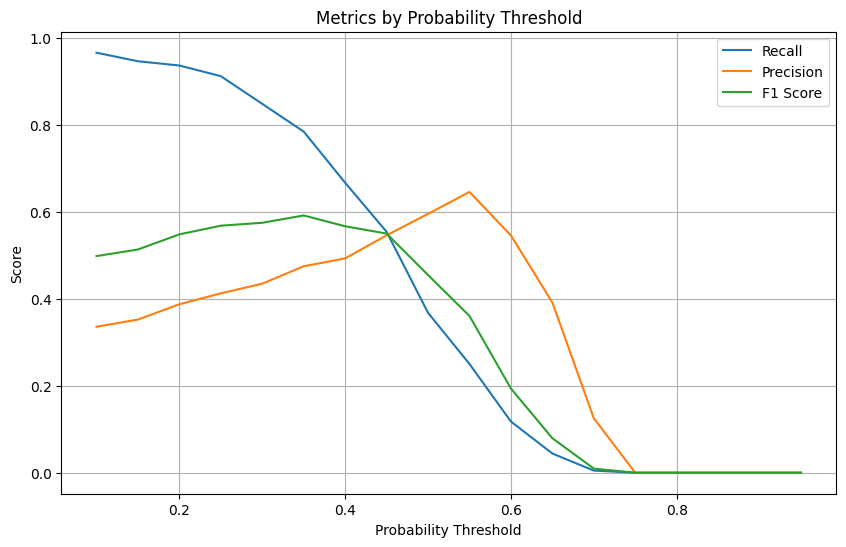

'Optimal Threshold for f1_scores:'

0.3500000000000001

'F1-score with optimal threshold:'

0.5679330328396651

'F1-score with optimal threshold:'

0.5914972273567468

In [19]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test_poly)[:, 1])

# Инициализируем списки, куда будем сохранять метрики
recall_scores = []
precision_scores = []
f1_scores = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Рассчитываем метрики и дополняем ими списки созданные ранее
    recall_scores.append(recall_score(y_test, y_test_pred_poly))
    precision_scores.append(precision_score(y_test, y_test_pred_poly))
    f1_scores.append(f1_score(y_test, y_test_pred_poly))

# Построим график зависимости метрик от порога вероятности
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Metrics by Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

# определяем оптимальный порог
optimal_threshold = thresholds[np.argmax(f1_scores)]
display("Optimal Threshold for f1_scores:", optimal_threshold)

# Предположительный наилучший порог вероятности
optimal_threshold = 0.35

# Делаем предсказание вероятности оттока для каждого клиента из тренировочной выборки
y_train_proba_pred = pd.Series(log_reg.predict_proba(X_train_poly)[:, 1])
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test_poly)[:, 1])

# Делаем предсказание классов с подобранным оптимальным порогом вероятности
y_train_pred_optimal = y_train_proba_pred.apply(lambda x: 1 if x > optimal_threshold else 0)
# Делаем предсказание классов с подобранным оптимальным порогом вероятности
y_test_pred_optimal = y_test_proba_pred.apply(lambda x: 1 if x > optimal_threshold else 0)

# Рассчитываем значение целевой метрики (например, F1-score) на тренировочной выборке
f1_optimal_train = f1_score(y_train, y_train_pred_optimal)
display("F1-score with optimal threshold:", f1_optimal_train)
# Рассчитываем значение целевой метрики (например, F1-score) на тестовой выборке
f1_optimal = f1_score(y_test, y_test_pred_optimal)
display("F1-score with optimal threshold:", f1_optimal)



> Небольшой вывод: Подбор оптимального порога вероятности улучшил результат

> Значения F1-score на тренировочной и тестовой выборках близки друг к другу и оба превышают 0.5. Это указывает на то, что модель не переобучена и не недообучена.

> Можно заключить, что модель хорошо сбалансирована и показывает устойчивую производительность как на тренировочных, так и на тестовых данных. Модель удовлетворяет критерию качества, и её можно считать достаточно точной для предсказания оттока клиентов.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [21]:
from sklearn import tree #модели деревьев решения
from sklearn import ensemble # ансамбли

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_unlim = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_unlim.fit(X_train, y_train)

#Делаем предсказание класса:
y_train_pred = dt_clf_unlim.predict(X_train)
y_test_pred = dt_clf_unlim.predict(X_test)

#Выводим значения метрики 
print('Train f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train f1_score: 1.00
Test f1_score: 0.57


> Приведенная выше модель является переобученной. Значение f1_score на тестовой выборке критично уступает этому значению на тренировочной выборке, где модель предсказывает значения на высочайшем уровне.

> Вероятно это связано с отсутствием ограничений по глубине и дерево продолжает делить имеющиеся данные до тех пор пока навернфяка не предскажет верный результат, это хорошо работает на тренировочных данных и плохо на тестовых. 

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_8 = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,  
    min_samples_leaf=10,   
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_8.fit(X_train, y_train)

#Делаем предсказание класса:
y_train_pred = dt_clf_8.predict(X_train)
y_test_pred = dt_clf_8.predict(X_test)

#Выводим значения метрики 
print('Train f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train f1_score: 0.72
Test f1_score: 0.64


> В результате легкого "груминга" удалось достичь лучшего результата. В итоге "стриженная" модель (с ограничением по глубене и количеству обьектов) делает предсказания лучше "лохматой". 

> Теперь метрики f1_score на тренировочной и тестовой выборке имеют меньшее расхождение и обе соответствует изначальному параметру обученности модели.

> Однако, так как нам важно минимизировать количество звонков и в то же время необходимо сохранить как можно больше клиентов, хотелось бы получить лучшее значение метрики f1_score.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
#Создаём объект класса случайный лес
rf_clf_t500 = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10, #количество объектов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_t500.fit(X_train, y_train)

#Делаем предсказание класса
y_train_pred = rf_clf_t500.predict(X_train)
y_test_pred = rf_clf_t500.predict(X_test)

#Выводим значения метрики 
print('Train f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train f1_score: 0.74
Test f1_score: 0.66


> В результате применения метода случайного леса метрика незначительно улучшилась на обоих выборках. Однако полученный результат зхначительно превосходит модель построенную методом логистической регресии с приминением полиноминальных признаков и подбором оптимального порога вероятности.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



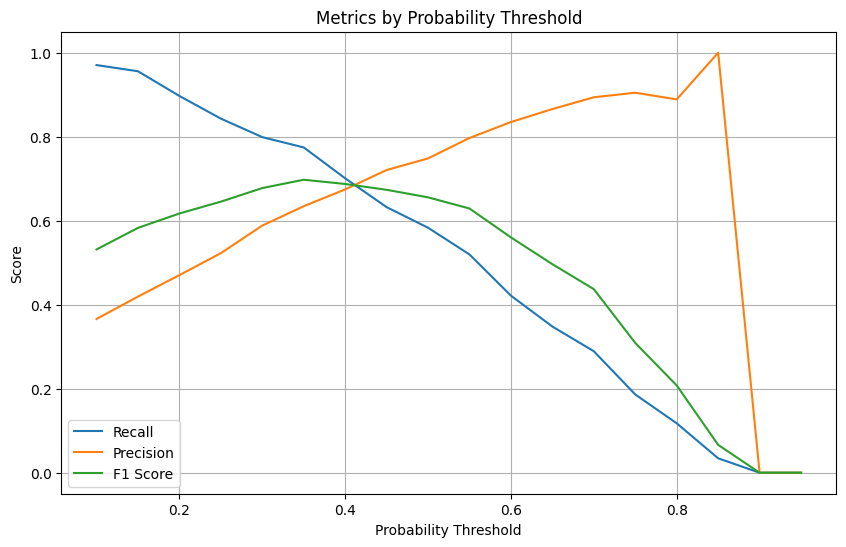

Optimal Threshold for f1_scores: 0.3500000000000001
Train F1-score with optimal threshold: 0.77
Test F1-score with optimal threshold: 0.70


In [25]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf_clf_t500.predict_proba(X_test)[:, 1])

# Инициализируем списки, куда будем сохранять метрики
recall_scores = []
precision_scores = []
f1_scores = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Рассчитываем метрики и дополняем ими списки созданные ранее
    recall_scores.append(recall_score(y_test, y_test_pred))
    precision_scores.append(precision_score(y_test, y_test_pred))
    f1_scores.append(f1_score(y_test, y_test_pred))

# Построим график зависимости метрик от порога вероятности
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Metrics by Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

# определяем оптимальный порог
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for f1_scores: {optimal_threshold}")

# Делаем предсказание вероятности оттока для каждого клиента из тренировочной выборки
y_train_proba_pred = pd.Series(rf_clf_t500.predict_proba(X_train)[:, 1])
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf_clf_t500.predict_proba(X_test)[:, 1])

# Делаем предсказание классов с подобранным оптимальным порогом вероятности
y_train_pred_optimal = y_train_proba_pred.apply(lambda x: 1 if x > optimal_threshold else 0)
# Делаем предсказание классов с подобранным оптимальным порогом вероятности
y_test_pred_optimal = y_test_proba_pred.apply(lambda x: 1 if x > optimal_threshold else 0)

# Рассчитываем значение целевой метрики (например, F1-score) на тренировочной выборке
print('Train F1-score with optimal threshold: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_optimal)))
# Рассчитываем значение целевой метрики (например, F1-score) на тестовой выборке
print('Test F1-score with optimal threshold: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_optimal)))


> Благодаря приминения оптимального порога вероятности удалось достичь максимальную метрику F1-score на тестовой выборке в проекте.

> Вывод: для предсказания минимизировации количества звонковклиентам и одновременно сохранения как можно большего числа клиентов наиболее подходит модель построенна на основе ансамблевого алгоритма "Случайный лес" с указанием оптимального порога вероятности.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [26]:
vasya_df = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Создаем новые признаки
vasya_df["BalanceSalaryRatio"] = vasya_df["Balance"] / vasya_df["EstimatedSalary"]
vasya_df["TenureByAge"] = vasya_df["Tenure"] / vasya_df["Age"]
vasya_df["CreditScoreGivenAge"] = vasya_df["CreditScore"] / vasya_df["Age"]

# Перекодируем оставшиеся текстовые признаки в бинарные столбцы
vasya_df["Gender"] = vasya_df["Gender"].map({"Male": 1, "Female": 0})

# Проверяем что количество признаков соответствует данным на которых обучалась модель
#display('Test shape: {}'.format(X_train.shape))
#display('Clientt shape: {}'.format(vasya_df.shape))

# Предсказываем вероятность оттока клиента с помощью Random Forest с подобранным оптимальным порогом вероятности
y_vasya_pred = pd.Series(rf_clf_t500.predict_proba(vasya_df)[:, 1])
print(f'Вероятность оттока клиента: {y_vasya_pred[0]*100:.2f} %')
y_vasya_pred_optimal = y_vasya_pred.apply(lambda x: 1 if x > optimal_threshold else 0)
if y_vasya_pred_optimal[0] == 1:
    print("ВНИМАЕНИЕ! Клиент утекает, нужно ему позвонить.")

Вероятность оттока клиента: 61.43 %
ВНИМАЕНИЕ! Клиент утекает, нужно ему позвонить.
